<a href="https://colab.research.google.com/github/lizhieffe/language_model/blob/main/6_Implementations_of_LMs_activations_gradients_batchnorm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- This colab helps to understand more about activations, gradients, and batch norm.

- It will help to understand why **RNN is harder to optimize** compared to CNN etc.

# Setup

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

# Load data

In [3]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

--2023-09-16 00:53:36--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.03s   

2023-09-16 00:53:36 (7.48 MB/s) - ‘names.txt’ saved [228145/228145]



['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
len(words)

32033

# Build vocabularoy

In [6]:
chars = sorted(list(set(''.join(words))))

stoi = {c: i+1 for i, c in enumerate(chars)}
stoi['.'] = 0

itos = {i: c for c, i in stoi.items()}

vocab_size = len(stoi)

assert vocab_size == 27

# Create DS

In [7]:
block_size = 3  # Context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X = []
  Y = []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      # print(f"{''.join(itos[c] for c in context)}--->{itos[ix]}")
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)

  return X, Y

In [8]:
import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

print(f'train: {len(Xtr)}, dev: {len(Xdev)}, test: {len(Xte)}')

train: 182625, dev: 22655, test: 22866


# MLP Revisited

## Model params

In [9]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn((n_hidden,), generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn((vocab_size,), generator=g)

parameters = [C, W1, b1, W2, b2]
n_params = sum(p.nelement() for p in parameters)
print(f'# of parameters: {n_params}')

for p in parameters:
  p.requires_grad = True

# of parameters: 11897


## Training loop

In [10]:
# same optimization as last time
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):

  # mini-batch
  ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  xemb = C[Xb]
  xemb.shape
  h = torch.tanh(xemb.view(-1, block_size * n_embd) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Yb) # loss function

  lossi.append(loss.log10().item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # Update params
  lr = 0.1 if i < 100_000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data -= 0.1 * p.grad

  # Track states
  if i % 10_000 == 0:
    print(f'{i}/{max_steps}: {loss.item():.4f}')

0/200000: 27.8817
10000/200000: 2.9415
20000/200000: 2.5069
30000/200000: 2.7998
40000/200000: 2.0261
50000/200000: 2.5863
60000/200000: 2.3420
70000/200000: 2.0952
80000/200000: 2.3454
90000/200000: 2.2365
100000/200000: 2.1080
110000/200000: 2.6963
120000/200000: 1.9808
130000/200000: 2.7478
140000/200000: 2.2104
150000/200000: 2.2696
160000/200000: 2.2313
170000/200000: 1.8774
180000/200000: 2.1382
190000/200000: 1.8206


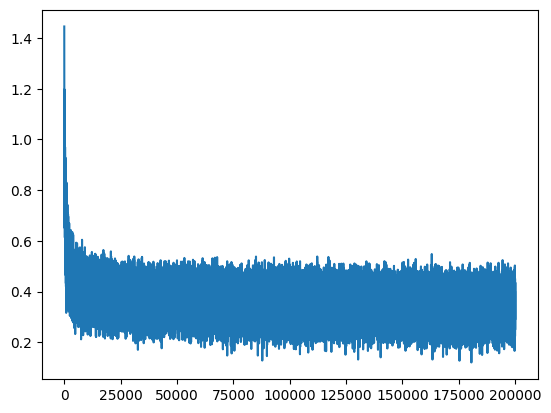

In [11]:
plt.plot(lossi)

## Obtain loss on DS splits

In [12]:
@torch.no_grad()  # This decorator disables gradient trackings
def split_loss(split):
  x, y = {
      'train': (Xtr, Ytr),
      'dev': (Xdev, Ydev),
      'test': (Xte, Yte),
  }[split]

  xemb = C[x]
  h = torch.tanh(xemb.view(-1, block_size * n_embd) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)

  return loss.item()

print(f'train loss = {split_loss("train")}, dev loss = {split_loss("dev")}')

train loss = 2.1910688877105713, dev loss = 2.2519688606262207


## Sample the model

In [13]:
for _ in range(20):
  context = [0] * block_size
  out = []

  while True:
    _tmp = torch.tensor([context])
    xemb = C[_tmp]

    h = torch.tanh(xemb.view(xemb.shape[0], -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)

    iy = torch.multinomial(probs, num_samples=1, replacement=True, generator=g)

    if iy == 0:
      break
    else:
      out.append(iy.item())
      context = context[1:] + [iy]

  print(''.join(itos[i] for i in out))

viyann
yuristen
wyn
kuo
edo
jayse
den
dailanii
dhiousarah
ose
naygoerop
ocrone
chukwu
giro
gruya
abeus
josefa
nolliah
quy
naziyan


# [Issue 1] Too big initial loss

- The loss (~27) for the 1st step of the training is too big. This indicates the params are not initialized with a good distribution.

- We can estimate a proper initial loss by assuming the tokens' distribution are uniformly distributed.

## Calculate proper initial loss

- Assume the tokens probability are uniformly distributed, the likelihood for each token is 1/27, so the loss (negative log likelihood) is 3.2958

In [14]:
logits = torch.ones((1, 27,)).float()
loss = F.cross_entropy(logits, torch.ones((1,)).long())

In [15]:
import math

assert loss.isclose(torch.tensor(-math.log(1/27)))

## Why the loss is high?

- Because the initial weights have **high confidence** on the wrong prediction. Or to say, **confidently wrong**

- The example below shows that the initial weight is very confident on `token[0]`, but the label is `token[2]`

- We want the initial logit to be **equal to form a uniform distribution of likelihood**, which gives a small initial loss

In [16]:
_tmp = torch.tensor([5.0, 0.0, 0.0, 0.0])
sm = F.softmax(_tmp, dim=0)
loss = -sm[2].log()
print(f'{loss.item()=:.4f}')

loss.item()=5.0200


## Approach: reduce the abs(logit)

- Change `b2` to 0
- Multiple `W2` by 0.1

Then we see

- the loss for the 1st iteration reduce from 27 to 4
- the loss after similar steps also improves

In [17]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn((n_hidden,), generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1
b2 = torch.randn((vocab_size,), generator=g) * 0

parameters = [C, W1, b1, W2, b2]
n_params = sum(p.nelement() for p in parameters)
print(f'# of parameters: {n_params}')

for p in parameters:
  p.requires_grad = True

# of parameters: 11897


In [ ]:
# same optimization as last time
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):

  # mini-batch
  ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  xemb = C[Xb]
  xemb.shape
  h = torch.tanh(xemb.view(-1, block_size * n_embd) @ W1 + b1)
  logits = h @ W2 + b2
  # print(f'{logits[0]=}')
  loss = F.cross_entropy(logits, Yb) # loss function

  lossi.append(loss.log10().item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # Update params
  lr = 0.1 if i < 100_000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data -= 0.1 * p.grad

  # Track states
  if i % 10_000 == 0:
    print(f'{i}/{max_steps}: {loss.item():.4f}')

  # break

0/200000: 4.2326
10000/200000: 2.1403
20000/200000: 2.4720
30000/200000: 2.5577
40000/200000: 2.0154
50000/200000: 2.4307
60000/200000: 2.3385
70000/200000: 2.0680


# Issue 2: small back propo gradients
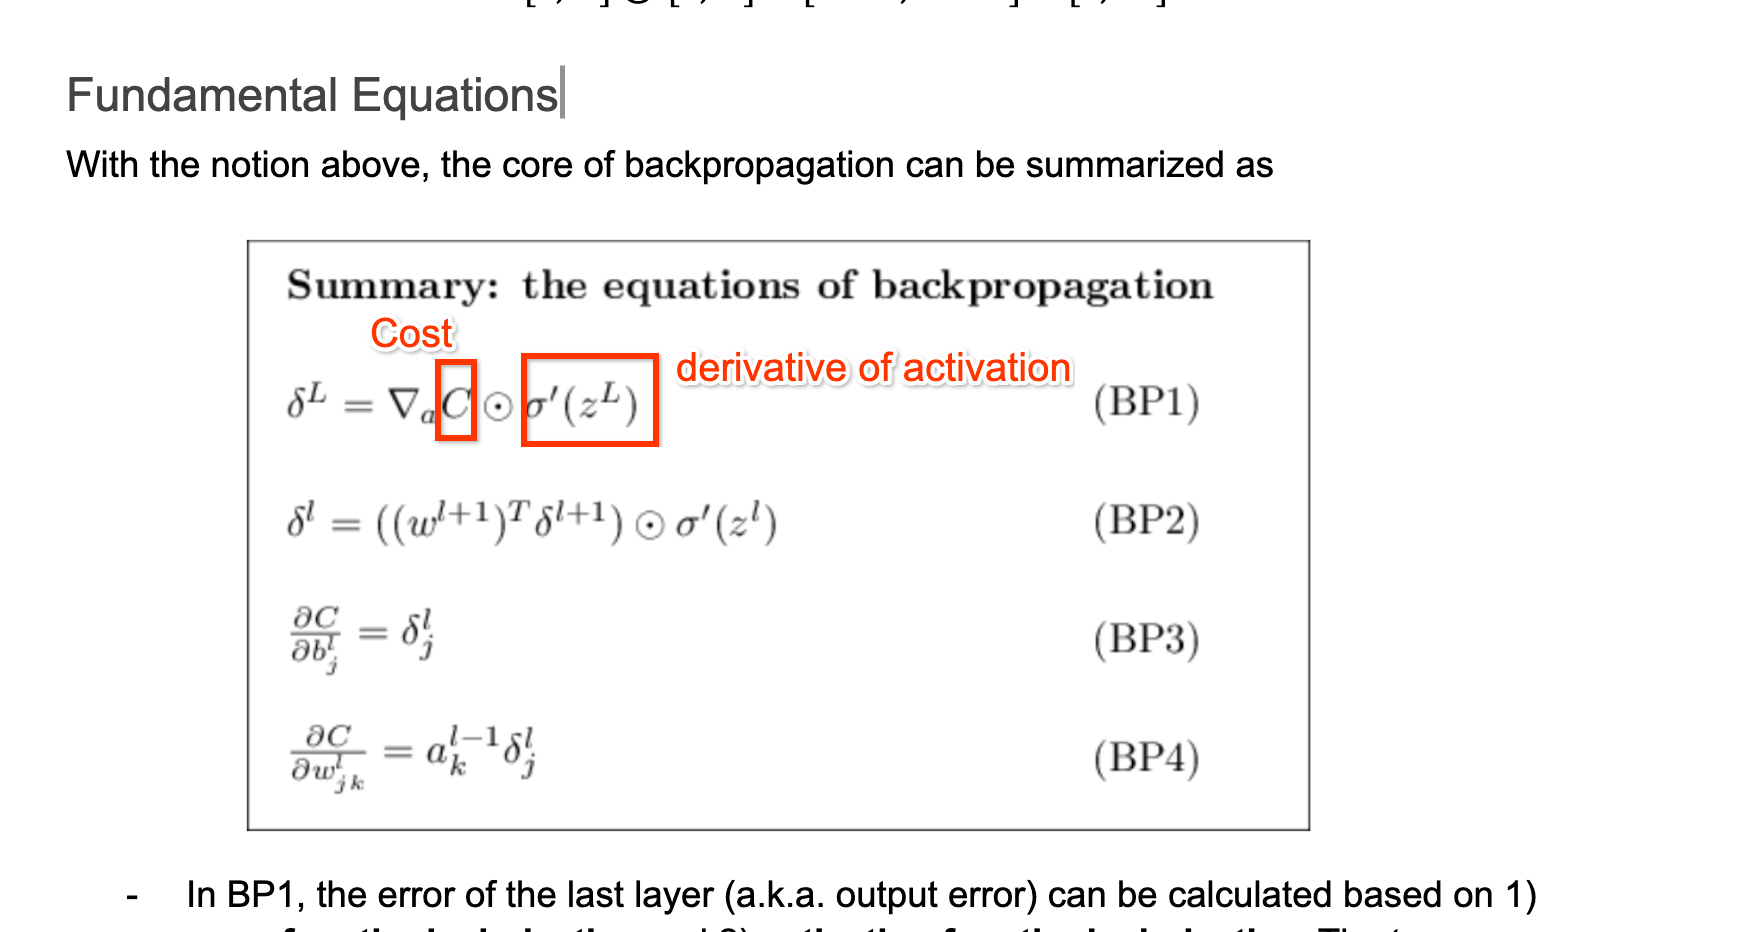

- Then hidden layer has `tanh()`. Similar to `relu`, when the value is close to -1 or 1, the **gradient is very small**.

- This causes the convergence to be **very slow**.

- The plot blow shows that **majority** of the h's values are close to -1 or 1 in the first iteration.

Common Activation

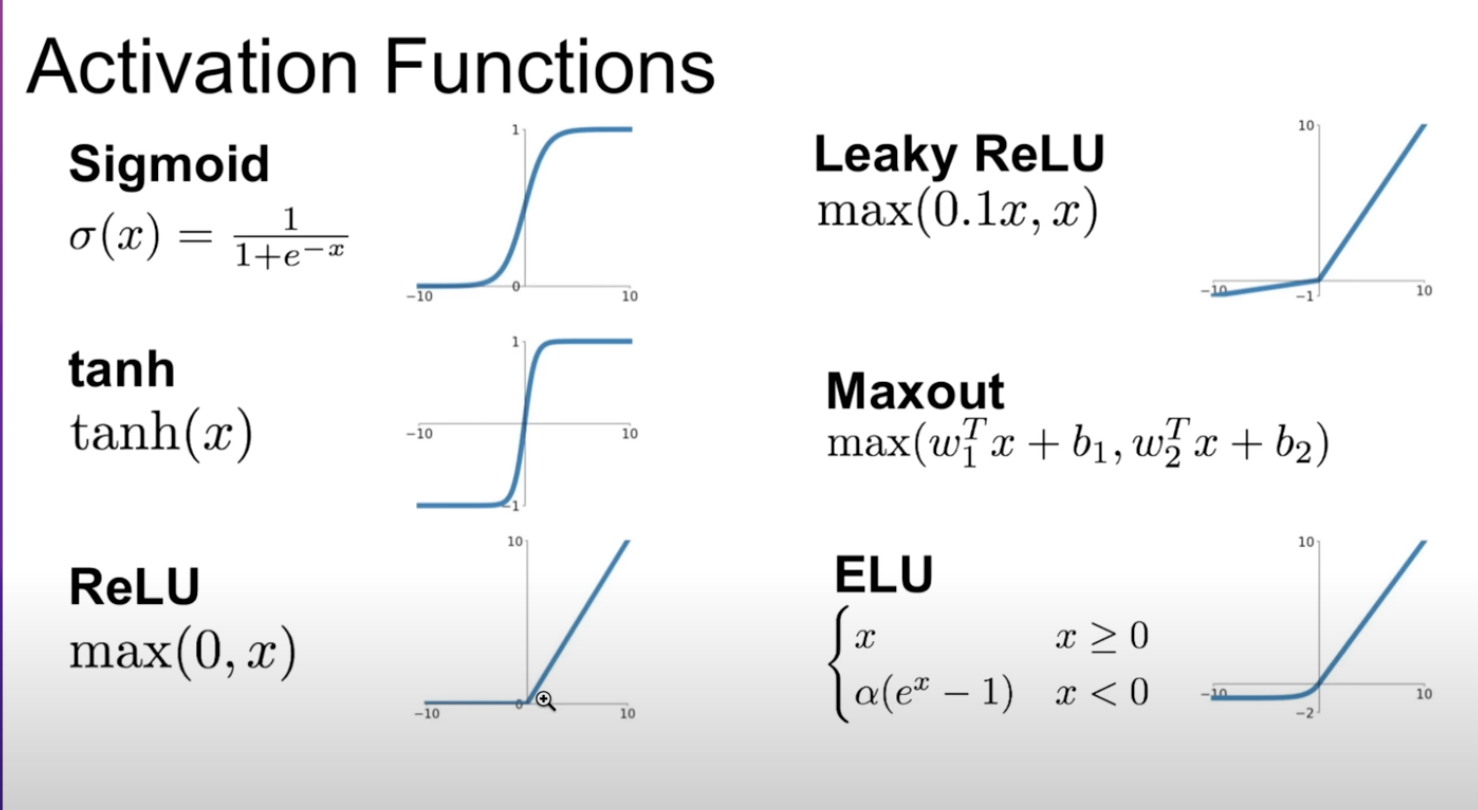

In [ ]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn((n_hidden,), generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1
b2 = torch.randn((vocab_size,), generator=g) * 0

parameters = [C, W1, b1, W2, b2]
n_params = sum(p.nelement() for p in parameters)
print(f'# of parameters: {n_params}')

for p in parameters:
  p.requires_grad = True

In [ ]:
# same optimization as last time
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):

  # mini-batch
  ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  xemb = C[Xb]
  xemb.shape
  h = torch.tanh(xemb.view(-1, block_size * n_embd) @ W1 + b1)
  logits = h @ W2 + b2
  # print(f'{logits[0]=}')
  loss = F.cross_entropy(logits, Yb) # loss function

  lossi.append(loss.log10().item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # Update params
  # lr = 0.1 if i < 100_000 else 0.01 # step learning rate decay
  # for p in parameters:
  #   p.data -= 0.1 * p.grad

  # Track states
  if i % 10_000 == 0:
    print(f'{i}/{max_steps}: {loss.item():.4f}')

  break

### Dead neuron

- The neuron corresponding to the **column with all white**, is dead neuron. The deal neuron never learns.

- Not the rows represent 32 **examples**, columns represent 200 **neurons**.

- Luckly we don't see a dead neuron below.

In [ ]:
plt.figure(figsize=(20,10))

# White color is for `true`.
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

In [ ]:
plt.hist(h.view(-1).tolist(), bins=50)

### When does small gradient or dead neuron happen?

1) During **initialization**. Params are initialized to the "dead" zone

2) During **optimization (back propo)**. When the learning rate is too large, it pushes the gradient to the "dead" zone hard. This is like a permanent brain damange to NN.

Our network is **simple**, so the training process is relatively **easy and foregiving** for a bad initial parameters. However this becomes a **bigger problem** when the network is **more complicated**, because the problems **stacks up**.

### Fix: make the `h` less extreme

The params are initialized using Normal (Gaussian) distribution. We will reduce the variations.

- `W1` is multipled by a small number `0.1`
- `b1` is multipled by a small number `0.01`. Here we don't se `b1` to 0 as the initial loss section does to `b2`, because it can add some variation to `h` and it can be good.

In [ ]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.1
b1 = torch.randn((n_hidden,), generator=g) *0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1
b2 = torch.randn((vocab_size,), generator=g) * 0

parameters = [C, W1, b1, W2, b2]
n_params = sum(p.nelement() for p in parameters)
print(f'# of parameters: {n_params}')

for p in parameters:
  p.requires_grad = True

In [ ]:
# same optimization as last time
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):

  # mini-batch
  ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  xemb = C[Xb]
  xemb.shape
  h = torch.tanh(xemb.view(-1, block_size * n_embd) @ W1 + b1)
  logits = h @ W2 + b2
  # print(f'{logits[0]=}')
  loss = F.cross_entropy(logits, Yb) # loss function

  lossi.append(loss.log10().item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # Update params
  lr = 0.1 if i < 100_000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data -= 0.1 * p.grad

  # Track states
  if i % 10_000 == 0:
    print(f'{i}/{max_steps}: {loss.item():.4f}')

  # break

In [ ]:
plt.figure(figsize=(20,10))

# White color is for `true`.
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

## Guideline for initialize the weights

### The Gaussian **expands** after multiplication

See the example below

- Initially the std dev for `x` is 1

- After multiplying `x` with `w` which also has std dev of 1, the result's std dev is 3.28

In [ ]:
x = torch.randn((1000, 10))
w = torch.randn((10, 100))
y = x @ w
print(f'{x.mean()=}, {x.std()=}')
print(f'{y.mean()=}, {y.std()=}')

plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), bins=50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), bins=50, density=True)

### Rule: **normalize the initialization of NN**, by dividing the sqrt of fan-in on the RHS

- The rule of thumb is to keep each layer with **Gaussian of std dev closed to 1**.

- This can be done by dividing the RHS of maxmul by the **sqrt of fan-in**.

- **fan-in** is the dimension of the 1st axis of the matrix

- This procedure is supported by PyTorch `kaiming_normal_` ([link](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_))

  - This is the **most common** way to initialize NN now.

A good paper to read is "[Delving Deep into Rectifiers ...](https://arxiv.org/abs/1502.01852)" by Kaiming He 2015

- it uses a **gain** of 0.5 (`0.5 * fan_in**0.5`), instead of gain of 1 (`1 * fan_in**0.5`(, because it compensate the ReLU which is non-zero on half of the space (x > 0) and effectively throws away half of the distribution.

  - **Gains are different for different non-linearity**. See [this doc](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.calculate_gain).

  - TODO: understand why exactly 0.5 helps

In [ ]:
x = torch.randn((1000, 10))

w = torch.randn((10, 100))

# Divid RHS by sqrt of fan-in
fan_in = w.shape[0]
w = w / fan_in**0.5

y = x @ w
print(f'{x.mean()=}, {x.std()=}')
print(f'{y.mean()=}, {y.std()=}')

plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), bins=50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), bins=50, density=True)

### Modern way of normalizations

- The **normalization for the initialization or NN** in the previous section was invented 7 years ago (2015). There are other approaches invented afterwards. The initialization normalization became less important.

- Example 1: **residual connection**

- Example 2: normalization **layers**

  - batch normalization

  - layer normalization

  - instance normalization

  - group normalization

- Example 3: better **optimizers** (Gradient descent was the 'old' classic one and what we write in this colab)

  - RMS prop

  - Adam

### What to do in practice

- Initialization normalization: it doesn't need to be very accurate because of the other morden approaches. Just divid by `fan_in**0.5`. If you really want to be more accurate, use e.g. `kaiming_normal_`

## [Solution 1] Implementation using Kaiming normalization

In [ ]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)

# Normalize via kaiming normalization for `tanh` so that the std dev for is 1
#
# `5/3` is the gain for `tanh()` activation https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.calculate_gain
# `n_embd * block_size` is the fan-in
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / (n_embd * block_size)**0.5
b1 = torch.randn((n_hidden,), generator=g) *0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1
b2 = torch.randn((vocab_size,), generator=g) * 0

parameters = [C, W1, b1, W2, b2]
n_params = sum(p.nelement() for p in parameters)
print(f'# of parameters: {n_params}')

for p in parameters:
  p.requires_grad = True

In [ ]:
# same optimization as last time
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):

  # mini-batch
  ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  xemb = C[Xb]
  xemb.shape
  h = torch.tanh(xemb.view(-1, block_size * n_embd) @ W1 + b1)
  logits = h @ W2 + b2
  # print(f'{logits[0]=}')
  loss = F.cross_entropy(logits, Yb) # loss function

  lossi.append(loss.log10().item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # Update params
  lr = 0.1 if i < 100_000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data -= 0.1 * p.grad

  # Track states
  if i % 10_000 == 0:
    print(f'{i}/{max_steps}: {loss.item():.4f}')

  break

In [ ]:
print(f'{h.std()=}')

In [ ]:
plt.figure(figsize=(20,10))

# White color is for `true`.
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

In [ ]:
plt.hist(h.view(-1).tolist(), bins=50)

## [Solution 2] Batch norm

- As discussed earlier, the precious initialization of params is not as important due to the modern innovation.

- The **batch norm** is one example

- It came out at 2015 from Google. [Paper](https://arxiv.org/abs/1502.03167)

- It is very **impactful** because it makes training the **very deep network very reliably**

- Idea: you have the hidden states, and you want them to be roughly Gaussian, then just take the **hidden states and normalize them to be (roughly) Gaussian**.

- Note this normalization is applied only to the **initialized params**. It is not applied once the training starts.

- The procecude (standarding the hidden state to Gaussian) is a **perfectly differentiable operation**.



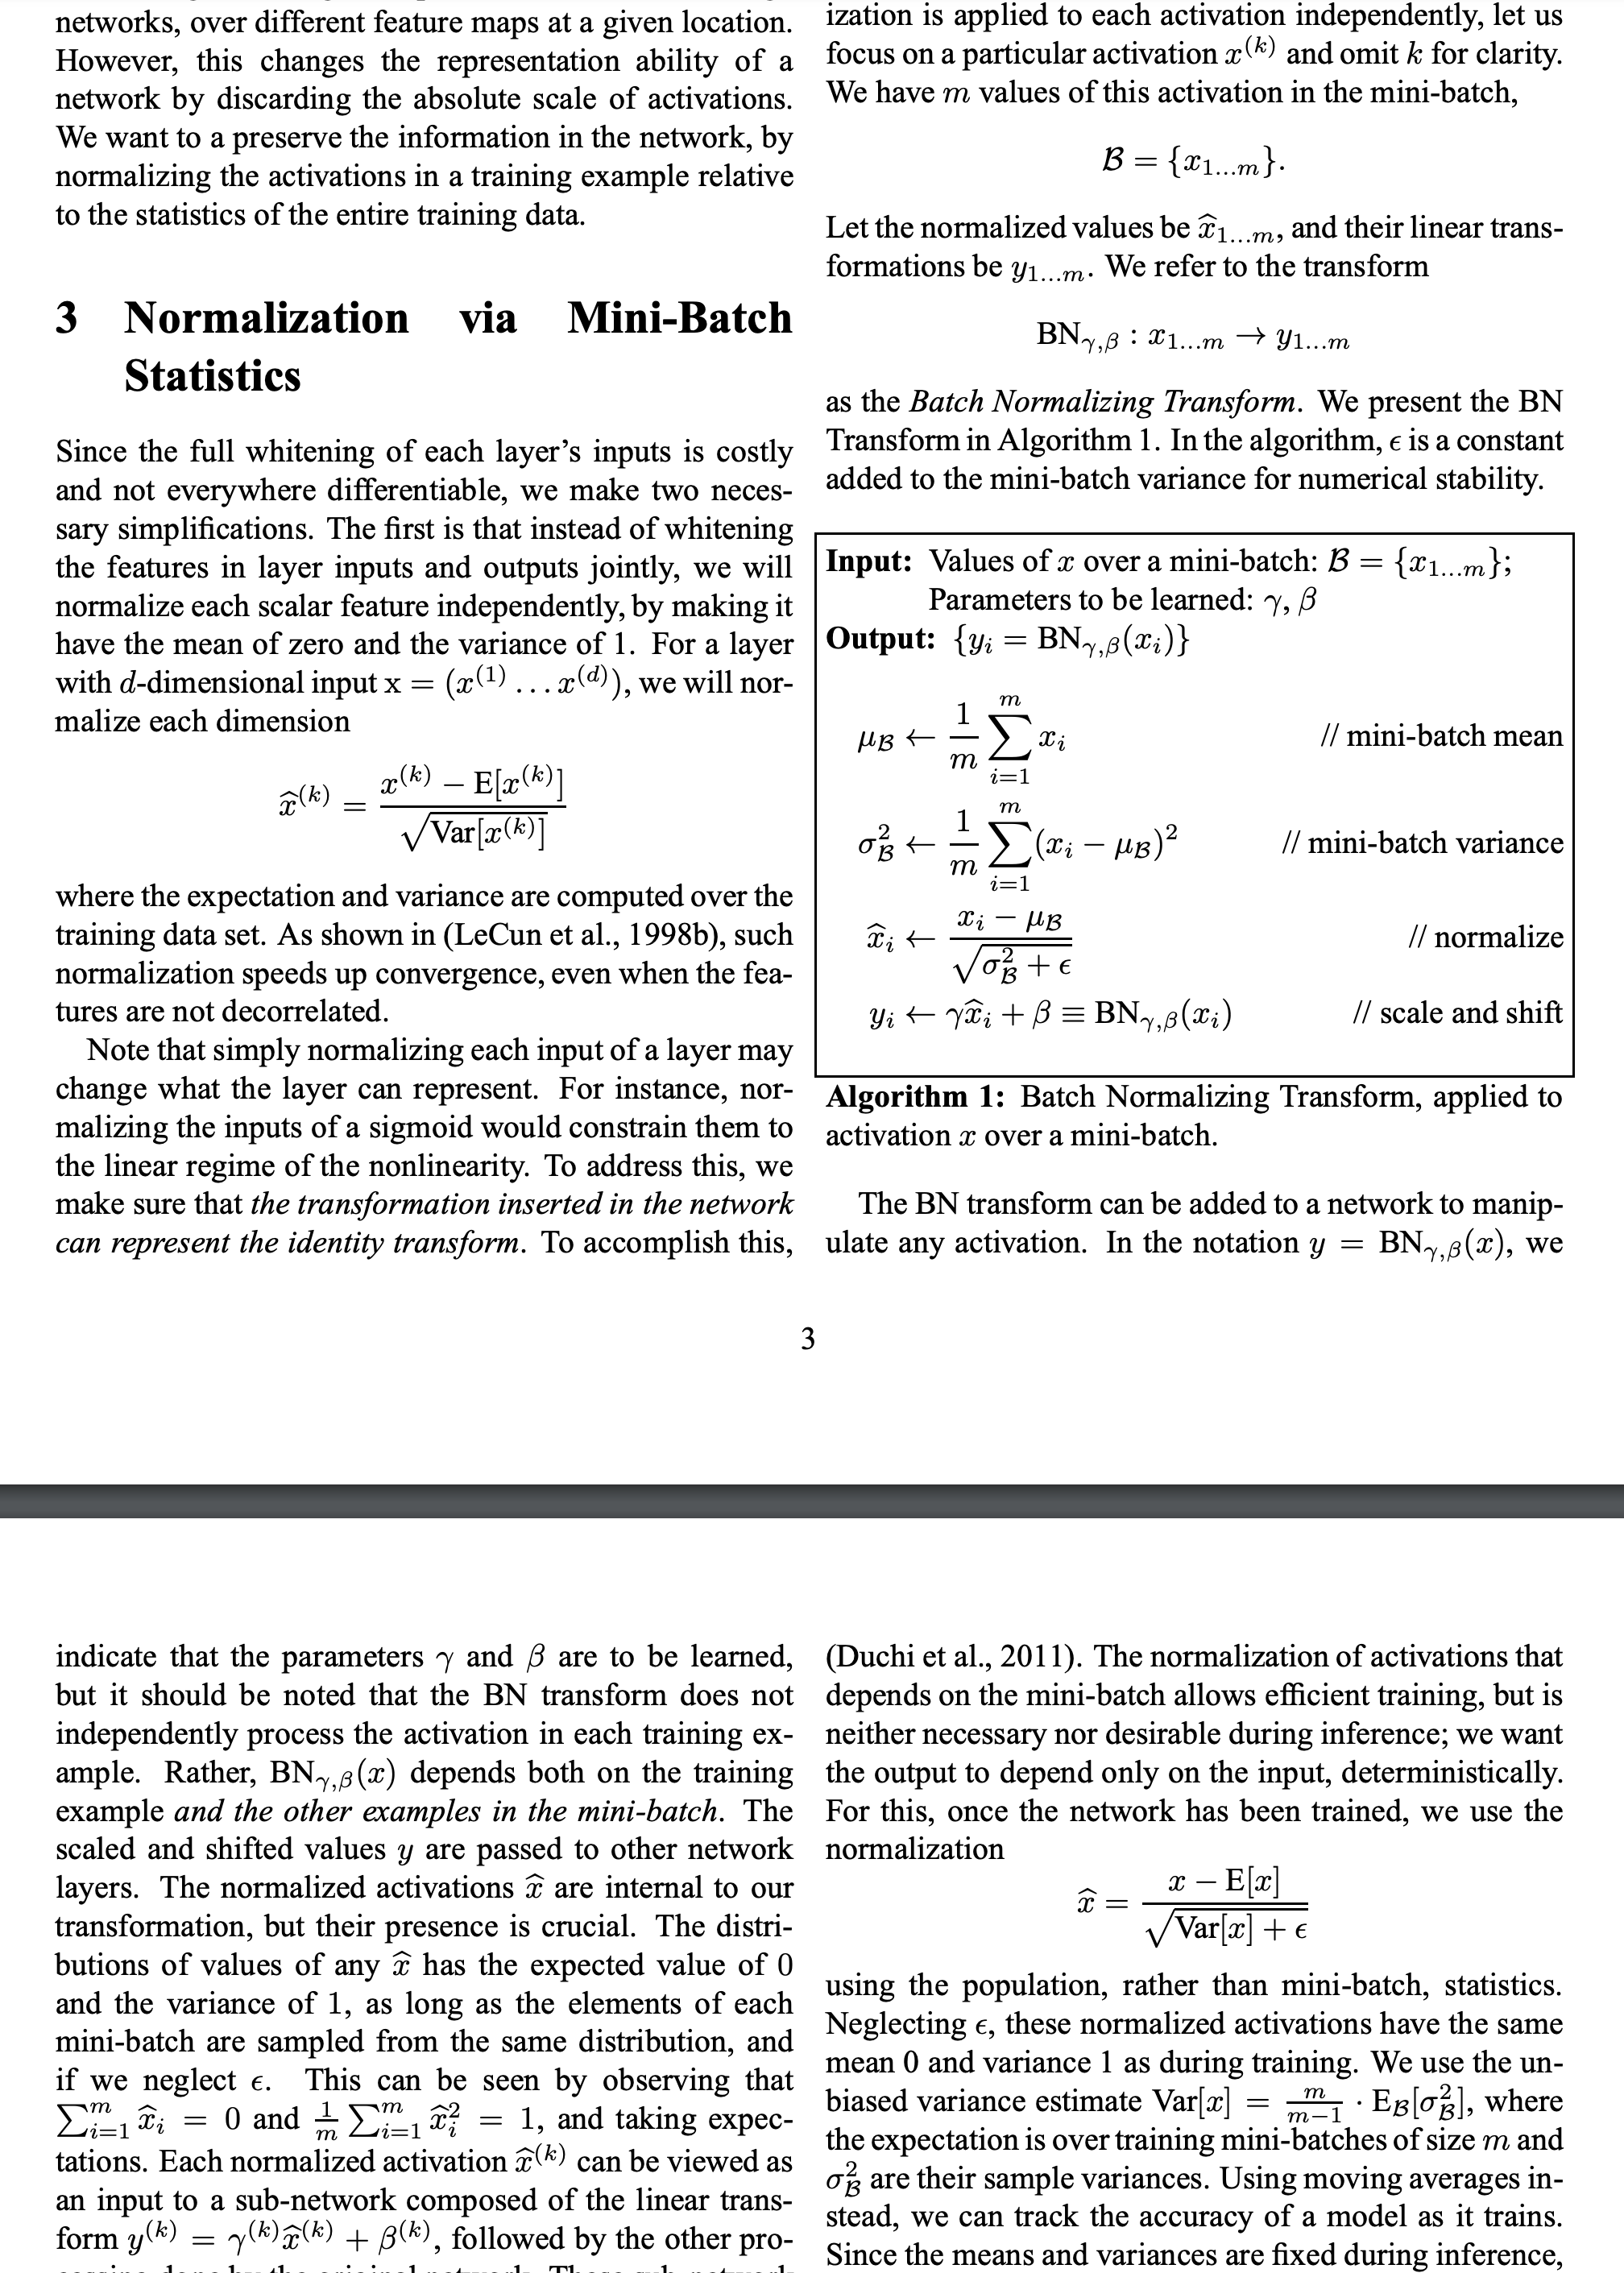

In [ ]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)

# Normalize via kaiming normalization for `tanh` so that the std dev for is 1
#
# `5/3` is the gain for `tanh()` activation https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.calculate_gain
# `n_embd * block_size` is the fan-in
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / (n_embd * block_size)**0.5
b1 = torch.randn((n_hidden,), generator=g) *0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1
b2 = torch.randn((vocab_size,), generator=g) * 0

# Related to the BN scale and shift
# This is related to the 4th equation in the box of the Batch Norm screenshot
bngain = torch.ones((1, n_hidden)).float()
bnbias = torch.zeros((1, n_hidden)).float()

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
n_params = sum(p.nelement() for p in parameters)
print(f'# of parameters: {n_params}')

for p in parameters:
  p.requires_grad = True

In [ ]:
# same optimization as last time
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):

  # mini-batch
  ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  xemb = C[Xb]
  xemb.shape

  # h pre activation
  hpreact = xemb.view(-1, block_size * n_embd) @ W1 + b1

  # Apply the BN normalize
  # This is the 3rd equation in the box of the Batch Norm screenshot
  hpreact = (hpreact - hpreact.mean(0, keepdim=True)) / (hpreact.std(0, keepdim=True))

  # Apply the BN scale and shift.
  # This is the 4th equation in the box of the Batch Norm screenshot
  hpreact = bngain * hpreact + bnbias

  h = torch.tanh(hpreact)

  logits = h @ W2 + b2
  # print(f'{logits[0]=}')
  loss = F.cross_entropy(logits, Yb) # loss function

  lossi.append(loss.log10().item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # Update params
  lr = 0.1 if i < 100_000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data -= 0.1 * p.grad

  # Track states
  if i % 10_000 == 0:
    print(f'{i}/{max_steps}: {loss.item():.4f}')

  # break

In [ ]:
@torch.no_grad()  # This decorator disables gradient trackings
def split_loss(split):
  x, y = {
      'train': (Xtr, Ytr),
      'dev': (Xdev, Ydev),
      'test': (Xte, Yte),
  }[split]

  xemb = C[x]

  # h pre activation
  hpreact = xemb.view(-1, block_size * n_embd) @ W1 + b1

  # Apply the BN normalize
  # This is the 3rd equation in the box of the Batch Norm screenshot
  hpreact = (hpreact - hpreact.mean(0, keepdim=True)) / (hpreact.std(0, keepdim=True))

  # Apply the BN scale and shift.
  # This is the 4th equation in the box of the Batch Norm screenshot
  hpreact = bngain * hpreact + bnbias

  h = torch.tanh(hpreact)

  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)

  return loss.item()

print(f'train loss = {split_loss("train")}, dev loss = {split_loss("dev")}')

### BN in practice

- In the current colab, because the model is simple, it is hard to see the benefit of BN. However, in the deep network there there are many layers and different operations, it is **hard to tune the distributions of the weights, and it is much easier to throw in BN layers**.

- In practice, it is very common to add BN for **all linear layers (like this colab) and CNN layers**.

### Cost of BN

- The benefit of BN comes with a cost

- Without BN, each example is **decoupled** from other examples, so the `h` calculated from an example is decoupled with other examples. The mini-batch is only an optimization; it doesn't affect the training result and the training forward and backward passes are determinstic. For a single example, the `h` has nothing to do with other examples in the batch.

- With BN, the examples in the mini-batch are **coupled**, the `h` calculated from an example is **coupled** and **affected** by other examples. The forward and backward passes are coupled with the choice of the mini-batch, because the mean and stddev are calcualted per mini-batch. For a single example, the `h` depends on the example itself, and also the other examples in the batch.

  - The (hopefully) small impact to `h`, `logits` or other, is called **jitter**.

  - The jitter seems a bug and undesirable, but actually **surprisingly good for network training**.

  - This can be think of as **regularization**. Each example is **regularized** by other examples in the batch, to make it harder to overfit for one individual example. It can also be think of as **data augmentation**.

- It does leads to bugs and weird behaviors, due to the examples are coupled mathematically. Because of this, people doesn't like it. Try to avoid it as much as possible. (Andrej has shot his foot many times :) )

- People does tried to deprecate it, and switch to other normalization techniques that don't have coupled examples in a batch, like *layer norm, instance norm, group norm*.

  - But it is **hard to migrate**, because batch norm works very well.

  - Batch norm is the **first introeduced** among the other norm techniques, and it is very popular and effective. It is the first time people can train deep network reliably.

### Example of a weird issue

- One question is during inference, since the model is setup to use a batch of examples, how to handle one single example?

#### Solution A: an extra step after training, to get the mean and std from all examples.

In [ ]:
# Calibrate the batch noorm at the end of training

with torch.no_grad():
  emb = C[Xtr]
  xpreact = emb.view(-1, block_size * n_embd) @ W1 + b1

  bnmean = xpreact.mean(0, keepdim=True)
  bnstd = xpreact.std(0, keepdim=True)

  print(f'{bnmean.shape=}, {bnstd.shape=}')

In [ ]:
@torch.no_grad()  # This decorator disables gradient trackings
def split_loss(split):
  x, y = {
      'train': (Xtr, Ytr),
      'dev': (Xdev, Ydev),
      'test': (Xte, Yte),
  }[split]

  xemb = C[x]

  # h pre activation
  hpreact = xemb.view(-1, block_size * n_embd) @ W1 + b1
  # Switch to use the pre-calculated `bnmean` and `bnstd`
  #
  # Apply the BN normalize
  # This is the 3rd equation in the box of the Batch Norm screenshot
  hpreact = (hpreact - bnmean) / bnstd

  # Apply the BN scale and shift.
  # This is the 4th equation in the box of the Batch Norm screenshot
  hpreact = bngain * hpreact + bnbias

  h = torch.tanh(hpreact)

  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)

  return loss.item()

print(f'train loss = {split_loss("train")}, dev loss = {split_loss("dev")}')

#### Solution B: calculate mean and std during training

- **Remove the extra stage** to calculate the BN mean and std compared to Solution A

- This is an nice improvement and used

In [ ]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)

# Normalize via kaiming normalization for `tanh` so that the std dev for is 1
#
# `5/3` is the gain for `tanh()` activation https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.calculate_gain
# `n_embd * block_size` is the fan-in
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / (n_embd * block_size)**0.5
b1 = torch.randn((n_hidden,), generator=g) *0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1
b2 = torch.randn((vocab_size,), generator=g) * 0

# Related to the BN scale and shift
# This is related to the 4th equation in the box of the Batch Norm screenshot
bngain = torch.ones((1, n_hidden)).float()
bnbias = torch.zeros((1, n_hidden)).float()

# This is part of Solution B.
#
# Store the BN mean and std across different batches.
# Mean is initialized to 0 because we know the mean is close to 0
# Std is initialized to 1 becasue we know the std is close to 1
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
n_params = sum(p.nelement() for p in parameters)
print(f'# of parameters: {n_params}')

for p in parameters:
  p.requires_grad = True

In [ ]:
# same optimization as last time
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):

  # mini-batch
  ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  xemb = C[Xb]
  xemb.shape

  # h pre activation
  hpreact = xemb.view(-1, block_size * n_embd) @ W1 + b1

  # This is part of Solution B.
  #
  # 1) It calculates the batch's mean and std.
  #
  # The global BN means and stds are updated during training to avoid
  # the extra stage after training as in the Solution A.
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
  bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

  # 2) Apply the BN normalize, to center the batch to be unit Gaussian.
  #
  # This is the 3rd equation in the box of the Batch Norm screenshot
  hpreact = (hpreact - bnmeani) / bnstdi

  # 3) Apply the BN scale and shift by the learned gain and bias.
  #
  # This is the 4th equation in the box of the Batch Norm screenshot
  hpreact = bngain * hpreact + bnbias

  h = torch.tanh(hpreact)

  logits = h @ W2 + b2
  # print(f'{logits[0]=}')
  loss = F.cross_entropy(logits, Yb) # loss function

  lossi.append(loss.log10().item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # Update params
  lr = 0.1 if i < 100_000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data -= 0.1 * p.grad

  # Track states
  if i % 10_000 == 0:
    print(f'{i}/{max_steps}: {loss.item():.4f}')

  # break

In [ ]:
@torch.no_grad()  # This decorator disables gradient trackings
def split_loss(split):
  x, y = {
      'train': (Xtr, Ytr),
      'dev': (Xdev, Ydev),
      'test': (Xte, Yte),
  }[split]

  xemb = C[x]

  # h pre activation
  hpreact = xemb.view(-1, block_size * n_embd) @ W1 + b1
  # Switch to use the pre-calculated `bnmean` and `bnstd`
  #
  # Apply the BN normalize
  # This is the 3rd equation in the box of the Batch Norm screenshot
  hpreact = (hpreact - bnmean_running) / bnstd_running

  # Apply the BN scale and shift.
  # This is the 4th equation in the box of the Batch Norm screenshot
  hpreact = bngain * hpreact + bnbias

  h = torch.tanh(hpreact)

  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)

  return loss.item()

print(f'train loss = {split_loss("train")}, dev loss = {split_loss("dev")}')

In [ ]:
bnstd

In [ ]:
bnstd_running

### Note

1) The epsilon in 3rd equation is a small number, to prevent the denominator be 0.

2) The bias term in the weight layer that have BM applied is not useful, because **it is immediately substract out** by the BM. The bias term can thus be ignored.

  - If you check the the grad of the bias term, it will always be zero.

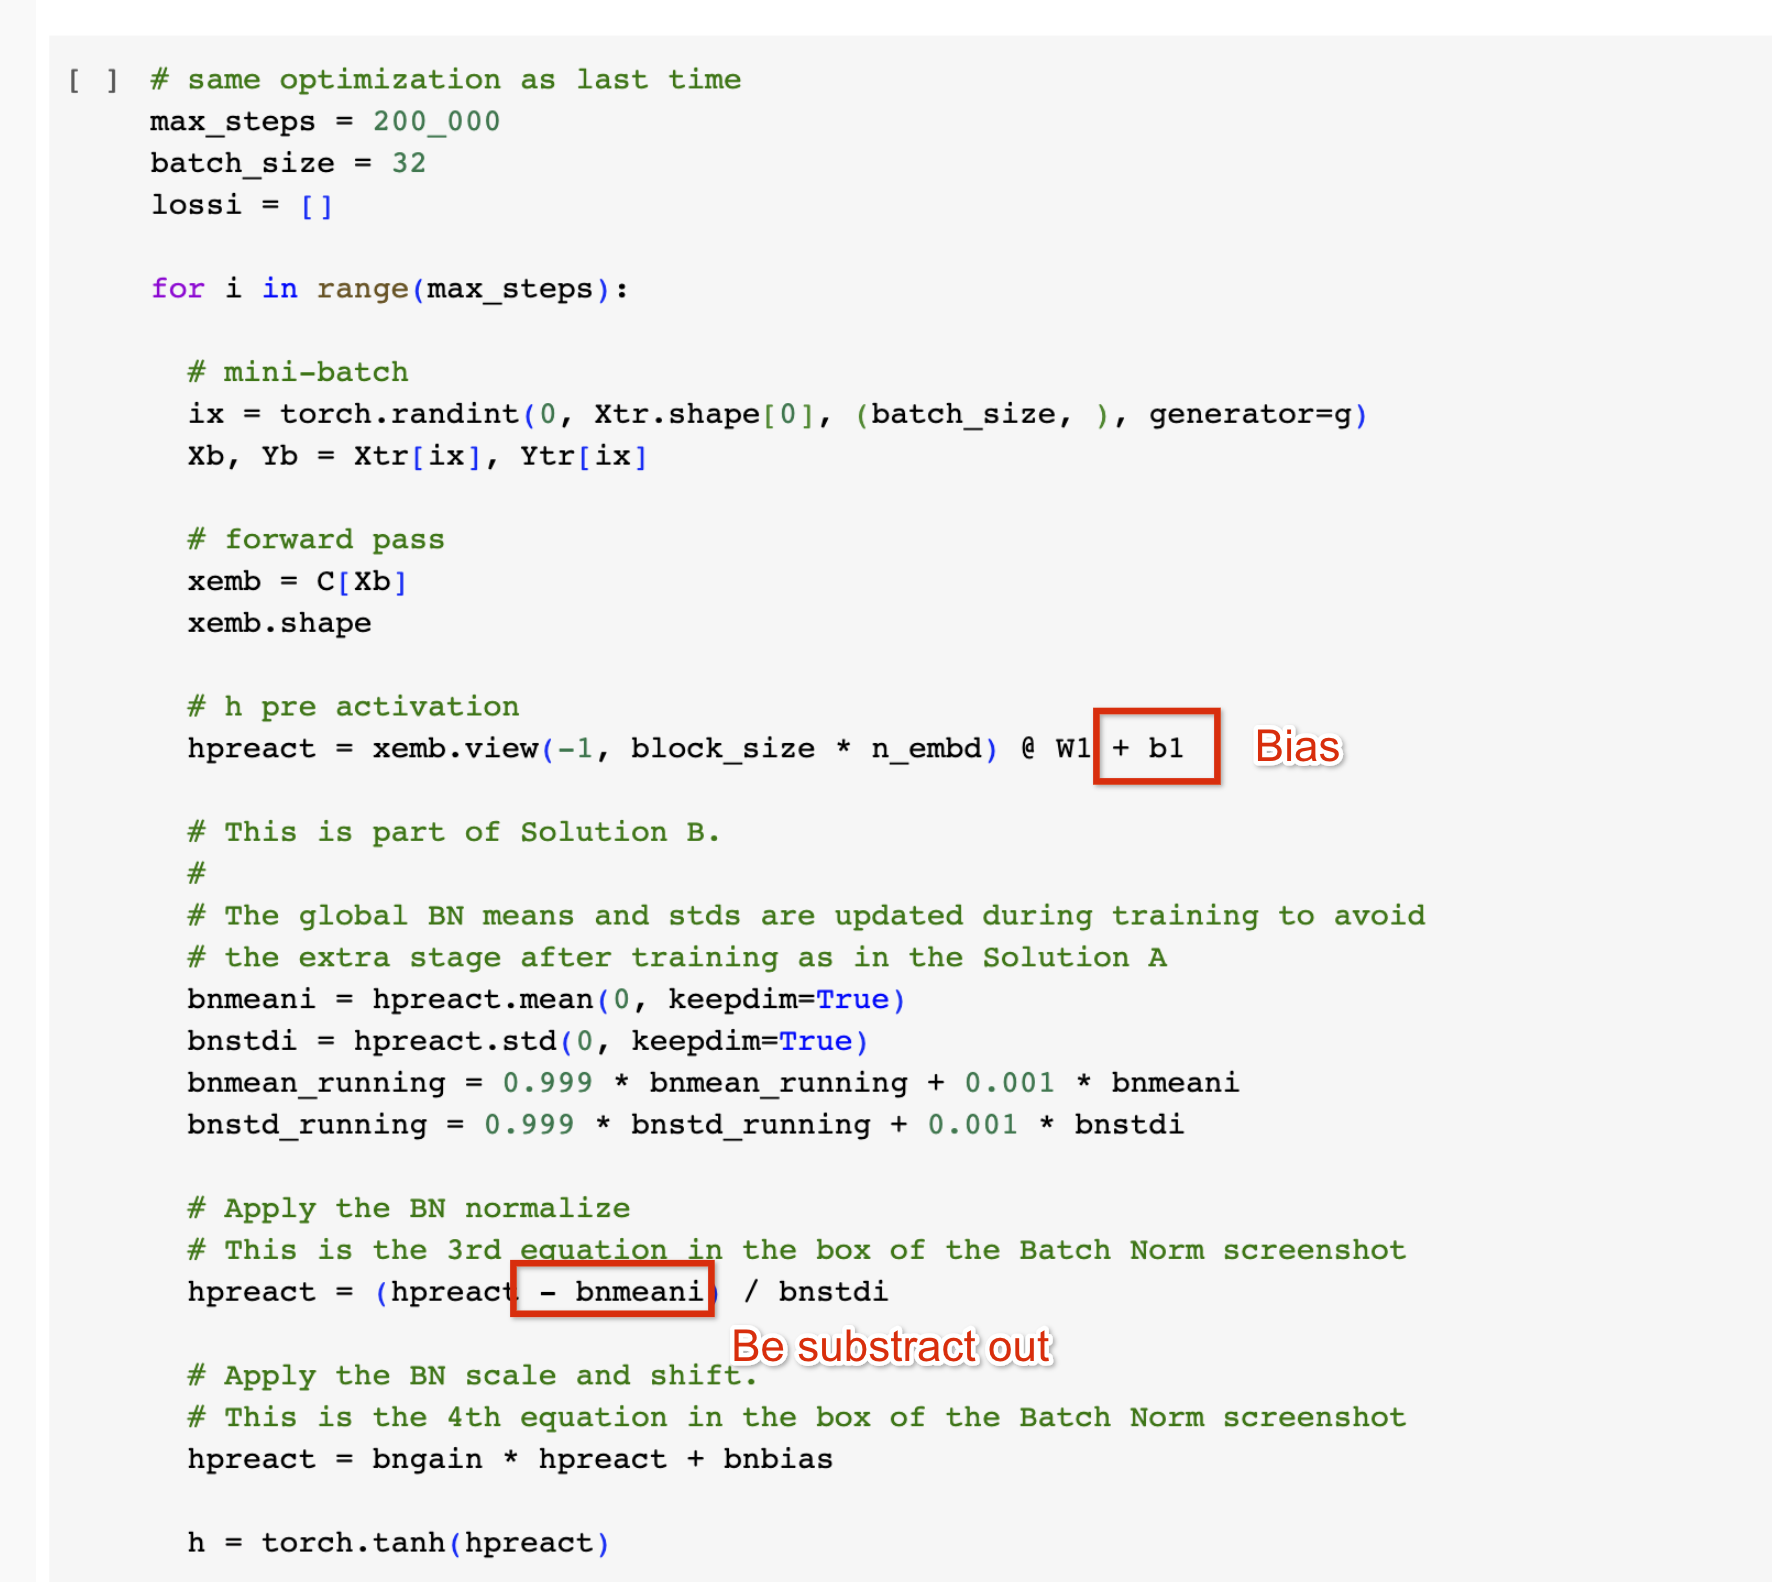

- The **momentum** the rate of updating the running means (0.001 in our case), when it is too large and the batch size is small, it may not converge well.

### Summry for BM

1) Used to control the **distribution of activation**

2) It is seen in many layers in network. Especially in the layers have **multiplications**, like *Linear layer (XW+B)*, *Convolution layer*, etc.

  - Usually: [weight layer (XW+B)]--->[normalization layer (BM)]---->[nonlinearity (activation)]

3) It has **two sets of params to learn**: *bngain, bnbias*

4) It has **two buffers** updated (not by backpropogated, instead by running-mean) during training: *bnmean_running, bnstd_running*

5) What it does

  a) calculate the **batch's mean and std**

  b) **center** the batch to be **unit Gaussian** by applying the mean and std

  c) **scale and shift** the batch by the **learned gain and bias**

  d) **buffer the running mean** of learned gain and bias, so that they can be used for inference.

### Example

ResNet

- It has a stack of [Bottleneck layers](https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py#L108)

- BN is applied in each Bottleneck after CNN.

- `bias` is [set to 0]() due to the exactly same reason that the bias has no use because it is canccelled out by the substraction of batch mean.

- It uses the pattern: [weight layer (XW+B)]--->[normalization layer (BM)]---->[nonlinearity (activation)]
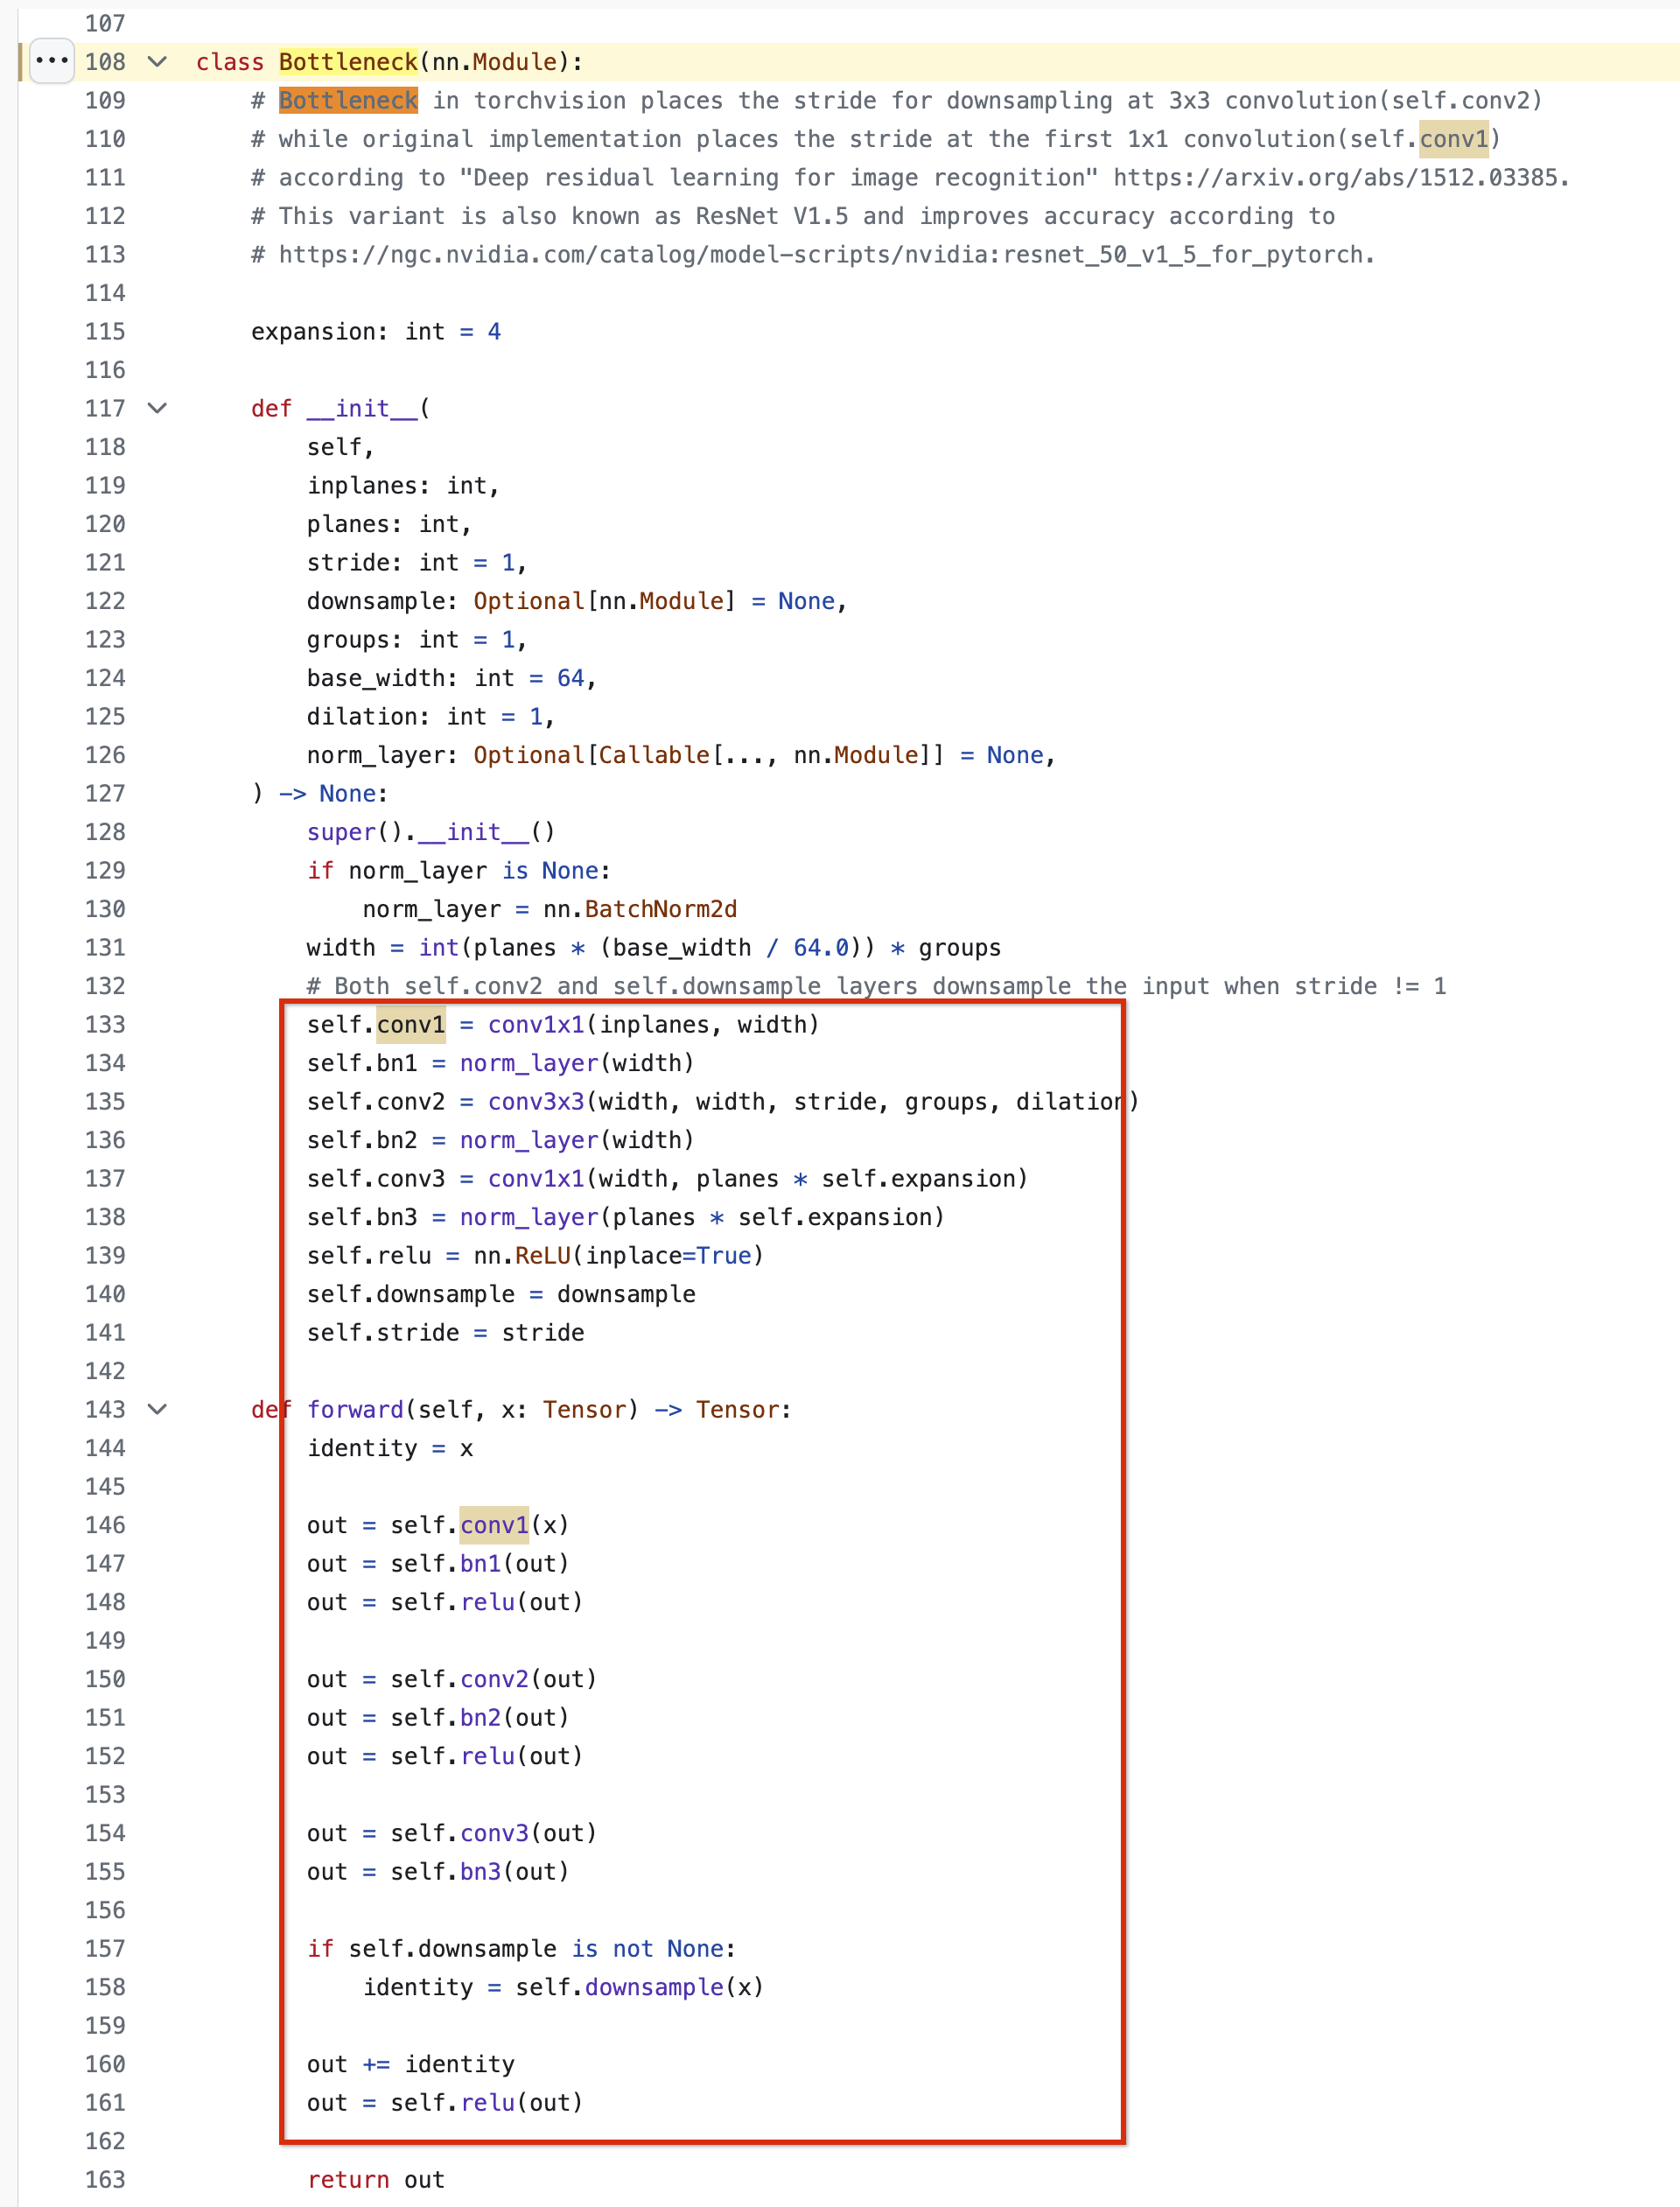

- It uses `ReLU` instead of `tanh()` like our example. Deep network typically and empirically have `ReLU` works better.

- `Linear` layer in PyTorch does the normalization by default. It is not exactly kaiming normalization but similar. E.g., it doesn't use exact correct gain, and it is uniform distribution.

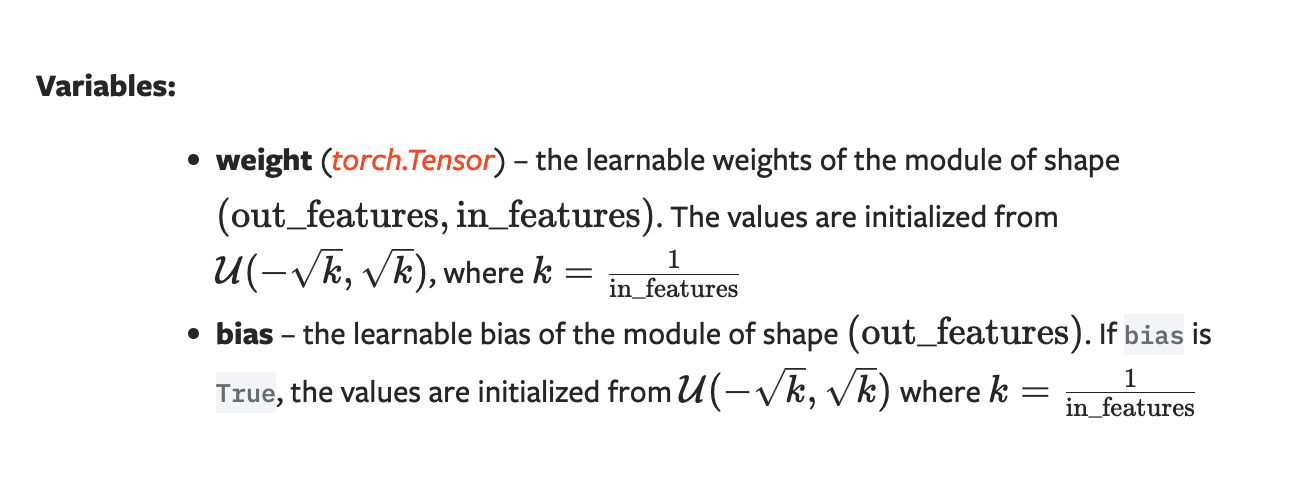

# Torchify the code

- Let's train a deeper network

In [1]:
class Linear:

  # fan_in: a common name for the input of the layer
  # fan_out: a common name for the output of the layer
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g)
    self.bias = torch.randn((fan_out,), generator=g) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])